In [1]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/face-mask-detection-dataset/CleanedData/data.npy
/kaggle/input/face-mask-detection-dataset/CleanedData/target.npy


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers

In [3]:
data = np.load('/kaggle/input/face-mask-detection-dataset/CleanedData/data.npy')

In [4]:
target = np.load('/kaggle/input/face-mask-detection-dataset/CleanedData/target.npy')
target = tf.keras.utils.to_categorical(target) # converting [1,0,1,1,0...] to [[1,0],[0,1],[1,0]] i.e categorical
target

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

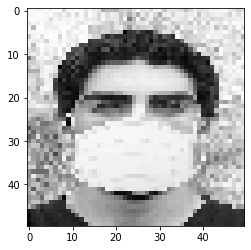

In [5]:
plt.imshow(data[890],cmap='gray')

In [6]:
target[890]

array([0., 1.], dtype=float32)

tf.image.grayscale_to_rgb(tf.convert_to_tensor(data[0].reshape((*data[0].shape,1)))).numpy().shape

In [7]:
# we need to create a 3D image since our image have only one channel as its a greyscale img.
# so we will just replicate the image 3 times to create a 3d image.
# for this process tf.image.grayscale_to_rgb comes handy.
# https://www.tensorflow.org/api_docs/python/tf/image/grayscale_to_rgb
# why RESHAPE - https://github.com/tensorflow/tensorflow/issues/26324 
# preprocessing
odata = data.copy()
ndata = []
for i in odata:
  image = i.reshape((*i.shape,1)) # as tf.image.grayscale_to_rgb requires last dimension to be 1, see why reshape link
  image = tf.convert_to_tensor(image)  # as tf.image.grayscale_to_rgb requires tensor for processing.
  ndata.append(tf.image.grayscale_to_rgb(image).numpy()/255.) # .numpy will convert dtype to numpy from tf

data = ndata.copy()

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
np.shape(data)

(1651, 50, 50, 3)

In [10]:
trainx, testx, trainy, testy = train_test_split(data,
                                                target,
                                                test_size=0.15,
                                                random_state=345,
                                                shuffle=True)
# we need to convert list to np array for tensorflow
trainx = np.array(trainx)
testx = np.array(testx)

In [11]:
trainy.shape

(1403, 2)

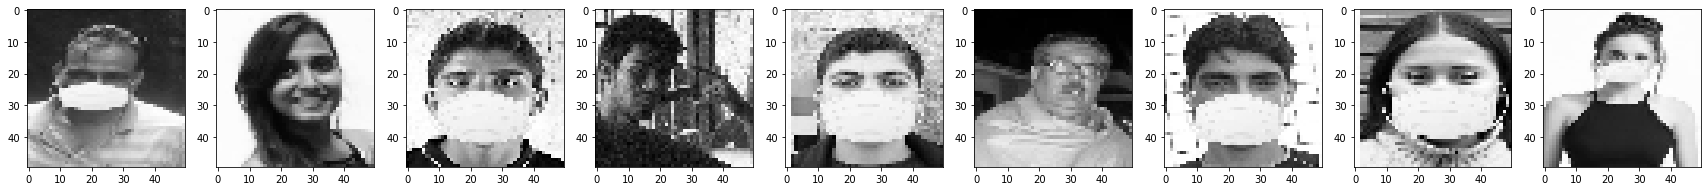

In [12]:
plt.figure(figsize=[30,30])
for i in np.arange(1,10):
    plt.subplot(int(f"19{i}"))
    plt.imshow(trainx[np.random.randint(0,1403)], cmap='gray')

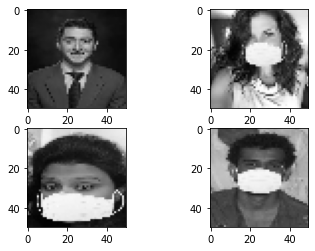

In [13]:
plt.subplot(221)
plt.imshow(trainx[np.random.randint(0,1440)], cmap='gray')
plt.subplot(222)
plt.imshow(trainx[np.random.randint(0,1440)], cmap='gray')
plt.subplot(223)
plt.imshow(trainx[np.random.randint(0,1440)], cmap='gray')
plt.subplot(224)
plt.imshow(trainx[np.random.randint(0,1440)], cmap='gray')

In [14]:
trainy[0]

array([0., 1.], dtype=float32)

In [15]:
img_shape = trainx[0].shape
img_shape  

(50, 50, 3)

In [16]:
model=Sequential()

model.add(layers.Conv2D(32,(3,3),input_shape=img_shape))
# model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(64,(3,3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(128,(3,3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(256,(3,3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))


model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.4))

model.add(layers.Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories


adam = tf.keras.optimizers.Adam(0.001)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
activation (Activation)      (None, 22, 22, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
activation_1 (Activation)    (None, 9, 9, 128)         0

In [18]:
# monitor = on which basis we have to select best model
# verbose = 0 i.e no message, 1 i.e update message.
model_saving_path = r'/tmp/checkpoint/cnn.model'
save_model = tf.keras.callbacks.ModelCheckpoint(model_saving_path,
                                                monitor='val_acc',
                                                save_best_only=True,
                                                mode='max',
                                                verbose=1)

In [19]:
history = model.fit(x=trainx,
                    y=trainy,
                    batch_size=100,
                    epochs=50,
                    callbacks=[save_model],
                    validation_split=0.2,
                    verbose=2,
                    shuffle=True)

Epoch 1/50
12/12 - 0s - loss: 0.6898 - accuracy: 0.5080 - val_loss: 0.6724 - val_accuracy: 0.4698
Epoch 2/50
12/12 - 0s - loss: 0.6103 - accuracy: 0.6551 - val_loss: 0.4686 - val_accuracy: 0.8470
Epoch 3/50
12/12 - 0s - loss: 0.5143 - accuracy: 0.7620 - val_loss: 0.3935 - val_accuracy: 0.8648
Epoch 4/50
12/12 - 0s - loss: 0.3592 - accuracy: 0.8592 - val_loss: 0.2552 - val_accuracy: 0.9039
Epoch 5/50
12/12 - 0s - loss: 0.2627 - accuracy: 0.9002 - val_loss: 0.1815 - val_accuracy: 0.9502
Epoch 6/50
12/12 - 0s - loss: 0.2135 - accuracy: 0.9225 - val_loss: 0.2269 - val_accuracy: 0.9075
Epoch 7/50
12/12 - 0s - loss: 0.2226 - accuracy: 0.9118 - val_loss: 0.1401 - val_accuracy: 0.9466
Epoch 8/50
12/12 - 0s - loss: 0.2033 - accuracy: 0.9305 - val_loss: 0.1620 - val_accuracy: 0.9502
Epoch 9/50
12/12 - 0s - loss: 0.1639 - accuracy: 0.9447 - val_loss: 0.1163 - val_accuracy: 0.9680
Epoch 10/50
12/12 - 0s - loss: 0.1408 - accuracy: 0.9501 - val_loss: 0.1203 - val_accuracy: 0.9644
Epoch 11/50
12/12 -

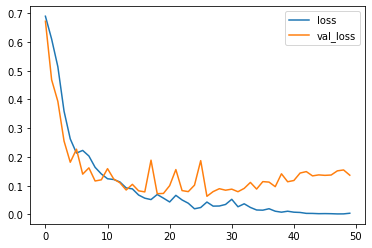

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])

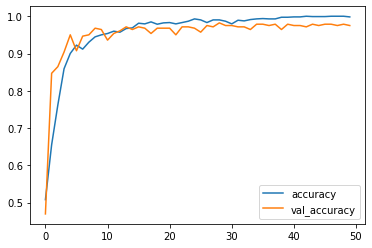

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

In [22]:
model.evaluate(testx, testy)

8/8 [==============================] - 0s 5ms/step - loss: 0.2527 - accuracy: 0.9556


[0.25268372893333435, 0.9556451439857483]

In [23]:
model.save('./')